In [39]:
# Step 1) Imports & Paths
# -----------------------------
import os, random, itertools, collections
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(42); random.seed(42); tf.random.set_seed(42)


In [26]:
#linking dataset
import kagglehub

path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
# dataset path
dataset_root = "/kaggle/input/fruit-and-vegetable-image-recognition"

train_dir = f"{dataset_root}/train"
val_dir   = f"{dataset_root}/validation"
test_dir  = f"{dataset_root}/test"


Using Colab cache for faster access to the 'fruit-and-vegetable-image-recognition' dataset.


In [27]:
print("Train classes:", os.listdir(train_dir)[:10], "...")
print("Val classes:", os.listdir(val_dir)[:10], "...")
print("Test classes:", os.listdir(test_dir)[:10], "...")

# Binary mapping: Fruit (1) vs Vegetable (0)
FRUIT_CLASSES = {
    'orange','pomegranate','pineapple','apple','kiwi','pear',
    'lemon','grapes','banana','watermelon','mango'
}
ALL_CLASSES = set(os.listdir(train_dir))
VEG_CLASSES = ALL_CLASSES - FRUIT_CLASSES

print("\n[Mapping]")
print("Fruits (1):", sorted(FRUIT_CLASSES))
print("Vegetables (0):", sorted(VEG_CLASSES))

# Feature-engineering defaults
IMG_SIZE = (150, 150)   # resize target (scaling)
BATCH    = 32
IMG_EXTS = ('.jpg','.jpeg','.png','.bmp','.gif','.tiff')

Train classes: ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger', 'raddish', 'pomegranate', 'pineapple', 'jalepeno'] ...
Val classes: ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger', 'raddish', 'pomegranate', 'pineapple', 'jalepeno'] ...
Test classes: ['capsicum', 'sweetcorn', 'orange', 'tomato', 'turnip', 'ginger', 'raddish', 'pomegranate', 'pineapple', 'jalepeno'] ...

[Mapping]
Fruits (1): ['apple', 'banana', 'grapes', 'kiwi', 'lemon', 'mango', 'orange', 'pear', 'pineapple', 'pomegranate', 'watermelon']
Vegetables (0): ['beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'jalepeno', 'lettuce', 'onion', 'paprika', 'peas', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip']


In [28]:
# Cleaning (skip corrupt/unreadable)

def is_ok_image(path):
    try:
        with Image.open(path) as im:
            im.verify()          # lightweight integrity check
        return True
    except Exception:
        return False

def collect_files_and_labels(split_dir):
    files, labels = [], []
    for cls in sorted(os.listdir(split_dir)):
        cls_path = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        label = 1 if cls in FRUIT_CLASSES else 0  # Fruit=1, Veg=0
        for r,_,names in os.walk(cls_path):
            for n in names:
                if n.lower().endswith(IMG_EXTS):
                    fp = os.path.join(r, n)
                    if is_ok_image(fp):           # <-- cleaning step
                        files.append(fp)
                        labels.append(label)
    return np.array(files), np.array(labels, dtype=np.int32)

train_files, train_labels = collect_files_and_labels(train_dir)
val_files,   val_labels   = collect_files_and_labels(val_dir)
test_files,  test_labels  = collect_files_and_labels(test_dir)

print(f"\n[After Cleaning] Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")


[After Cleaning] Train: 3115 | Val: 351 | Test: 359


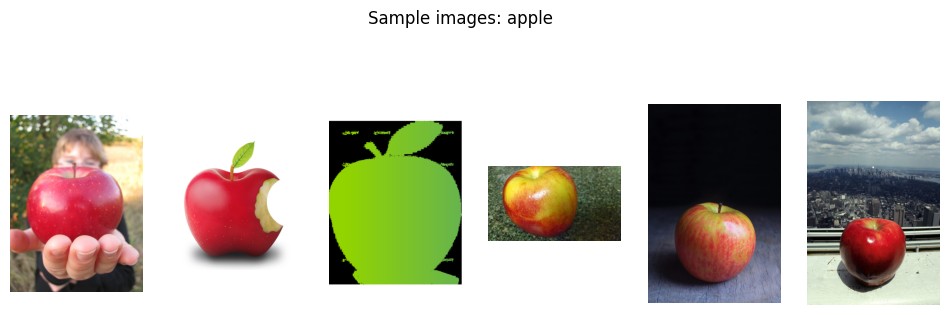

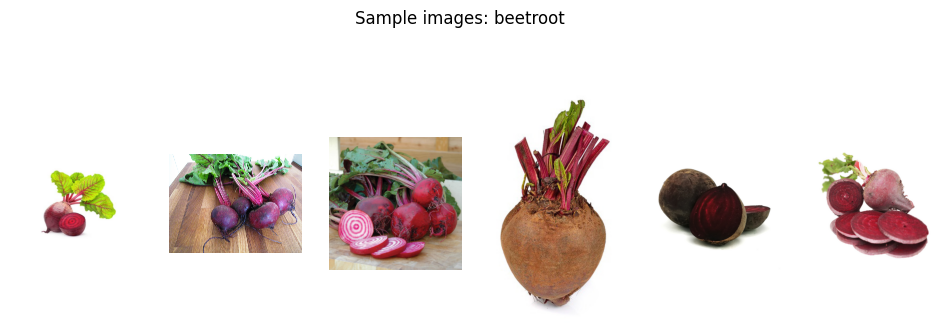

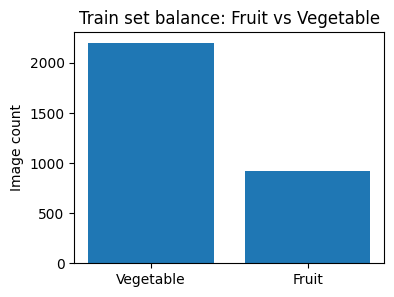

{'Vegetable': 2196, 'Fruit': 919}


In [29]:
# Step 3) EDA (samples + class balance)
# -----------------------------
def show_samples_from_folder(folder, title, n=6):
    paths = []
    for r,_,fs in os.walk(folder):
        for f in fs:
            if f.lower().endswith(IMG_EXTS):
                paths.append(os.path.join(r,f))
    n = min(n, len(paths))
    if n == 0:
        print("No images found in:", folder); return
    plt.figure(figsize=(12,4))
    for i in range(n):
        img = Image.open(random.choice(paths)).convert("RGB")
        plt.subplot(1,n,i+1); plt.imshow(img); plt.axis("off")
    plt.suptitle(title); plt.show()

# pick one fruit and one vegetable class that exist
fruit_example = next((c for c in sorted(FRUIT_CLASSES) if c in ALL_CLASSES), None)
veg_example   = next((c for c in sorted(VEG_CLASSES)   if c in ALL_CLASSES), None)
if fruit_example: show_samples_from_folder(os.path.join(train_dir, fruit_example), f"Sample images: {fruit_example}")
if veg_example:   show_samples_from_folder(os.path.join(train_dir, veg_example),   f"Sample images: {veg_example}")

fruit_count = int((train_labels == 1).sum())
veg_count   = int((train_labels == 0).sum())
plt.figure(figsize=(4,3))
plt.bar(['Vegetable','Fruit'], [veg_count, fruit_count])
plt.title('Train set balance: Fruit vs Vegetable')
plt.ylabel('Image count')
plt.show()
print({"Vegetable": veg_count, "Fruit": fruit_count})

In [30]:
 # Outliers (IQR on image area) + graphs
# -----------------------------
def gather_areas(files, max_n=3000):
    areas = []
    for i, fp in enumerate(files[:max_n]):
        try:
            with Image.open(fp) as im:
                w, h = im.size
            areas.append(w*h)
        except:
            pass
    return np.array(areas)

areas = gather_areas(train_files)
if len(areas) < 10:
    # fallback if sample too small; use broad bounds
    LOW, HIGH = 0, 1e12
else:
    q1, q3 = np.percentile(areas, [25, 75])
    iqr = q3 - q1
    LOW, HIGH = q1 - 1.5*iqr, q3 + 1.5*iqr

print(f"\n[Outlier area bounds] {int(LOW)} .. {int(HIGH)} (pixels)")



[Outlier area bounds] -1814000 .. 4160400 (pixels)


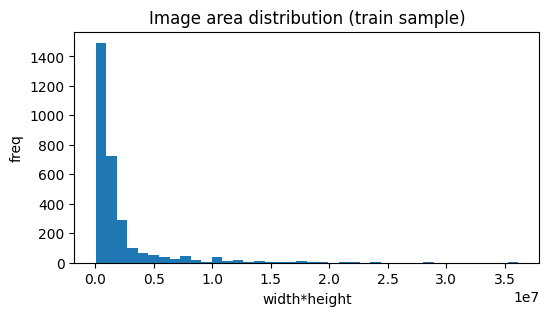

/tmp/ipython-input-4174414809.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(areas, vert=True, labels=['area'])


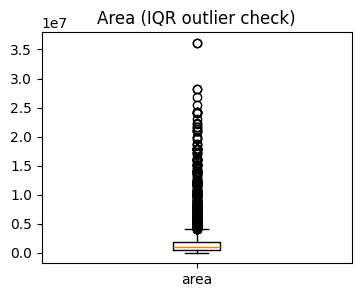

In [31]:
# Graphs
if len(areas) > 0:
    plt.figure(figsize=(6,3))
    plt.hist(areas, bins=40)
    plt.title("Image area distribution (train sample)")
    plt.xlabel("width*height"); plt.ylabel("freq"); plt.show()

    plt.figure(figsize=(4,3))
    plt.boxplot(areas, vert=True, labels=['area'])
    plt.title("Area (IQR outlier check)"); plt.show()


In [32]:
#Feature Engineering / Scaling (tf.data)
#  - resize to IMG_SIZE
#  - normalize to [0,1]
#  - filter area outliers
#  - augment (train only)
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE

def load_and_filter(path, label, img_size=IMG_SIZE):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    shape = tf.shape(img)[:2]
    area  = tf.cast(shape[0]*shape[1], tf.float32)
    ok    = tf.logical_and(area >= LOW, area <= HIGH)

    def _ok():
        x = tf.image.resize(img, img_size)
        x = tf.cast(x, tf.float32) / 255.0
        return x, tf.cast(label, tf.float32)
    def _bad():  # mark for drop
        x = tf.zeros((img_size[0], img_size[1], 3), tf.float32)
        return x, tf.constant(-1.0)

    return tf.cond(ok, _ok, _bad)

augment = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

def make_ds(files, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if training:
        ds = ds.shuffle(min(len(files), 2048), reshuffle_each_iteration=True)
    ds = ds.map(lambda p,l: load_and_filter(p,l), num_parallel_calls=AUTOTUNE)
    ds = ds.filter(lambda x,y: tf.not_equal(y, -1.0))  # drop flagged outliers
    if training:
        ds = ds.map(lambda x,y: (augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_files, train_labels, training=True)
val_ds   = make_ds(val_files,   val_labels,   training=False)
test_ds  = make_ds(test_files,  test_labels,  training=False)

for xb, yb in train_ds.take(1):
    print("\n[Sample batch] images:", xb.shape, "| labels:", yb[:10].numpy())



[Sample batch] images: (32, 150, 150, 3) | labels: [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]


In [33]:
#Class Weights for imbalance

from collections import Counter
cw = Counter(train_labels.tolist())
total = cw[0] + cw[1]
class_weight = {
    0: total/(2*cw[0]+1e-9),
    1: total/(2*cw[1]+1e-9)
}
print("\nClass weights (optional):", class_weight)



Class weights (optional): {0: 0.709244080145558, 1: 1.6947769314463033}


In [34]:
#Modeling (CNN)
model = Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE[0],IMG_SIZE[1],3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Fruit=1, Veg=0
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,713 (36.48 MB)

 Trainable params: 9,563,713 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
     86/Unknown 70s 745ms/step - accuracy: 0.6830 - loss: 0.6521

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


86/86 ━━━━━━━━━━━━━━━━━━━━ 78s 841ms/step - accuracy: 0.6834 - loss: 0.6515 - val_accuracy: 0.7083 - val_loss: 0.5530 - learning_rate: 0.0010
Epoch 2/6
86/86 ━━━━━━━━━━━━━━━━━━━━ 71s 823ms/step - accuracy: 0.7393 - loss: 0.5306 - val_accuracy: 0.7396 - val_loss: 0.4876 - learning_rate: 0.0010
Epoch 3/6
86/86 ━━━━━━━━━━━━━━━━━━━━ 70s 821ms/step - accuracy: 0.7513 - loss: 0.4976 - val_accuracy: 0.7292 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 4/6
86/86 ━━━━━━━━━━━━━━━━━━━━ 70s 816ms/step - accuracy: 0.7731 - loss: 0.4740 - val_accuracy: 0.7951 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 5/6
86/86 ━━━━━━━━━━━━━━━━━━━━ 70s 816ms/step - accuracy: 0.7725 - loss: 0.4806 - val_accuracy: 0.7812 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 6/6
86/86 ━━━━━━━━━━━━━━━━━━━━ 69s 811ms/step - accuracy: 0.7694 - loss: 0.4935 - val_accuracy: 0.8403 - val_loss: 0.3612 - learning_rate: 0.0010


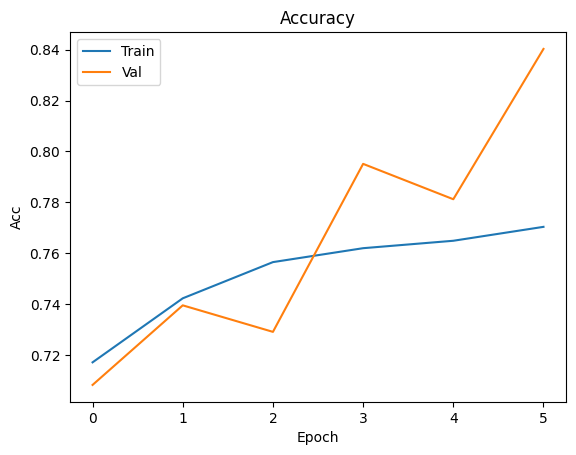

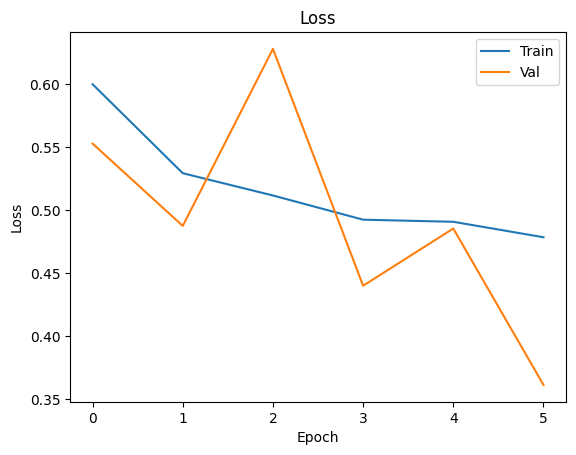


Validation Accuracy: 84.03%
Test Accuracy: 84.35%


In [35]:
#training
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
EPOCHS = 6

# To use class weights, add: class_weight=class_weight
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# -----------------------------
#  Evaluation (plots + metrics)
# -----------------------------
plt.figure(); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend(['Train','Val']); plt.show()

plt.figure(); plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(['Train','Val']); plt.show()

val_loss, val_acc = model.evaluate(val_ds, verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nValidation Accuracy: {val_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


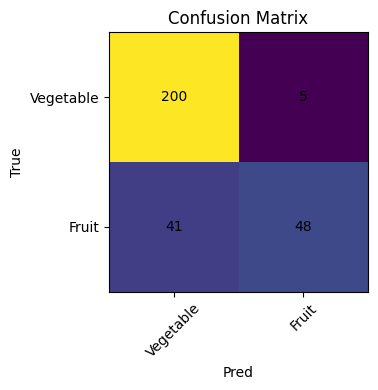


Classification Report:
               precision    recall  f1-score   support

   Vegetable       0.83      0.98      0.90       205
       Fruit       0.91      0.54      0.68        89

    accuracy                           0.84       294
   macro avg       0.87      0.76      0.79       294
weighted avg       0.85      0.84      0.83       294



In [42]:
# Confusion matrix + report on TEST
# Create a dataset for prediction without batching and prefetching
test_ds_predict = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_ds_predict = test_ds_predict.map(lambda p,l: load_and_filter(p,l), num_parallel_calls=AUTOTUNE)
test_ds_predict = test_ds_predict.filter(lambda x,y: tf.not_equal(y, -1.0)) # drop flagged outliers
test_ds_predict = test_ds_predict.batch(1) # Add batch of 1 for prediction

y_prob = model.predict(test_ds_predict, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Filter test_labels to match the samples in test_ds_predict
test_labels_filtered = test_labels[
    np.array([is_ok_image(f) and (Image.open(f).size[0]*Image.open(f).size[1] >= LOW) and (Image.open(f).size[0]*Image.open(f).size[1] <= HIGH) for f in test_files])
]


cm = confusion_matrix(test_labels_filtered, y_pred)

def plot_cm(cm, classes=('Vegetable','Fruit'), normalize=False, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xticks([0,1], classes, rotation=45); plt.yticks([0,1], classes)
    for i in range(2):
        for j in range(2):
            txt = f"{cm[i,j]:.2f}" if normalize else f"{cm[i,j]}"
            plt.text(j, i, txt, ha='center', va='center')
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

plot_cm(cm, normalize=False)
print("\nClassification Report:\n", classification_report(test_labels_filtered, y_pred, target_names=['Vegetable','Fruit']))

In [43]:
#Save model

save_path = "/kaggle/working/fruit_vs_veg_binary.h5" if os.path.exists("/kaggle/working") else "/content/fruit_vs_veg_binary.h5"
model.save(save_path)
print("\nModel saved to:", save_path)

print("\nDONE ✅  (Headings covered: Loading, Verify, Cleaning, EDA, Outliers, Feature Eng+Scaling, Modeling, Training, Evaluation, Save)")


Model saved to: /content/fruit_vs_veg_binary.h5

DONE ✅  (Headings covered: Loading, Verify, Cleaning, EDA, Outliers, Feature Eng+Scaling, Modeling, Training, Evaluation, Save)
